# Replication: Predicting Disk Replacement towards Reliable Data Centers

Source: https://www.kdd.org/kdd2016/papers/files/adf0849-botezatuA.pdf


## Data Pipeline 

### Legend:
Lines with ending with arrows represent one data file being the dependency for another, while lines without arrows represent a file being contained in a directory.
 
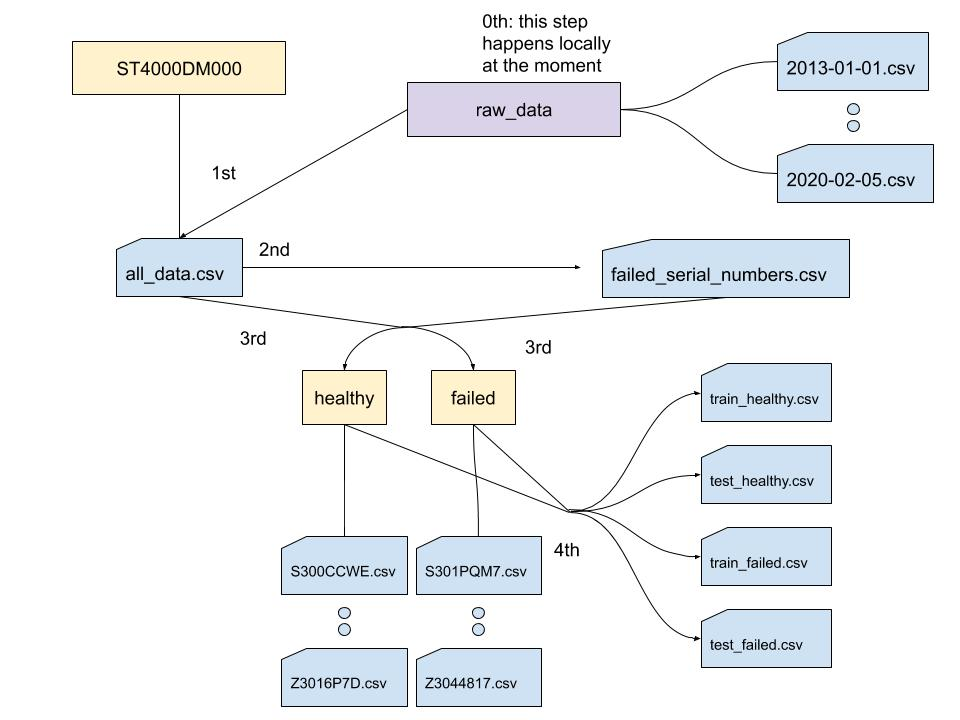

## Pre-processing the raw data


In [2]:
import os
from pathlib import Path
import sys
import pandas as pd

In [38]:
# smart特征
SMART_ATTRIBUTES = ['smart_1_normalized', 'smart_1_raw', 'smart_2_normalized', 'smart_2_raw', 'smart_3_normalized',
                    'smart_3_raw', 'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized', 'smart_5_raw',
                    'smart_7_normalized', 'smart_7_raw', 'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized',
                    'smart_9_raw', 'smart_10_normalized', 'smart_10_raw', 'smart_11_normalized', 'smart_11_raw',
                    'smart_12_normalized', 'smart_12_raw', 'smart_13_normalized', 'smart_13_raw', 'smart_15_normalized',
                    'smart_15_raw', 'smart_22_normalized', 'smart_22_raw', 'smart_183_normalized', 'smart_183_raw',
                    'smart_184_normalized', 'smart_184_raw', 'smart_187_normalized', 'smart_187_raw',
                    'smart_188_normalized', 'smart_188_raw', 'smart_189_normalized', 'smart_189_raw',
                    'smart_190_normalized', 'smart_190_raw', 'smart_191_normalized', 'smart_191_raw',
                    'smart_192_normalized', 'smart_192_raw', 'smart_193_normalized', 'smart_193_raw',
                    'smart_194_normalized', 'smart_194_raw', 'smart_195_normalized', 'smart_195_raw',
                    'smart_196_normalized', 'smart_196_raw', 'smart_197_normalized', 'smart_197_raw',
                    'smart_198_normalized', 'smart_198_raw', 'smart_199_normalized', 'smart_199_raw',
                    'smart_200_normalized', 'smart_200_raw', 'smart_201_normalized', 'smart_201_raw',
                    'smart_220_normalized', 'smart_220_raw', 'smart_222_normalized', 'smart_222_raw',
                    'smart_223_normalized', 'smart_223_raw', 'smart_224_normalized', 'smart_224_raw',
                    'smart_225_normalized', 'smart_225_raw', 'smart_226_normalized', 'smart_226_raw',
                    'smart_240_normalized', 'smart_240_raw', 'smart_241_normalized', 'smart_241_raw',
                    'smart_242_normalized', 'smart_242_raw', 'smart_250_normalized', 'smart_250_raw',
                    'smart_251_normalized', 'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
                    'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized', 'smart_255_raw']

我们现在有2015-01~2015-12月的数据，硬盘有很多牌子，不同牌子的特征分布不一样，所以不能一起进行训练

我们打算挑ST4000DM000和HDS722020ALA330型号的硬盘进行学习，之后将学习好的模型在其他牌子的硬盘上进行迁移学习

我们将在ST31500541AS和HDS5C3030ALA630型号的硬盘上测试迁移学习的模型效果如何

由于每个硬盘都有unique的serial number，所以对于mode为ST4000DM000的硬盘，我们首先将其分为failed的硬盘和healthy的硬盘

and then for the folder 'failed' and folder 'healthy',they include many hard disk'csv files,evry csv file name is a unique erial number

so we can think a csv file is a time series of a hard disk

In [81]:
# test
HARD_DRIVE_MODEL = ['ST4000DM000','Hitachi HDS722020ALA330']
'''
我们可以看到，ST4000DM000和HDS722020ALA330型号的硬盘样本数量大，且特征缺失值较少
'''
DATA_SOURCE = Path('data/raw_data')
files = [file for file in os.listdir(DATA_SOURCE)]
file=files[0]
df = pd.read_csv(DATA_SOURCE / file)
name=[x for x in df.groupby('model').groups]
length=[len(v) for v in df.groupby('model').groups.values()]
res=[*zip(name,length)]
res.sort(key=lambda x:x[1],reverse=True)
'''数量前10多的硬盘型号'''
res[:10]
df.sort_values(by='date')

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2013-04-10,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,3000592982016,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14133,2013-04-10,JK1101B9JRM31F,Hitachi HDS722020ALA330,2000398934016,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14132,2013-04-10,MJ1311YNG5U38A,Hitachi HDS5C3030ALA630,3000592982016,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14131,2013-04-10,S1F0QWEQ,ST3000DM001,3000592982016,0,NaN,36172072,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14130,2013-04-10,S1F06XLZ,ST3000DM001,3000592982016,0,NaN,36049376,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7062,2013-04-10,S1F0L1XN,ST3000DM001,3000592982016,0,NaN,77959496,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7061,2013-04-10,MJ1323YNG1R3GC,Hitachi HDS5C3030ALA630,3000592982016,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7060,2013-04-10,MJ0351YNG9YJNA,Hitachi HDS5C3030ALA630,3000592982016,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7058,2013-04-10,MJ0351YNG9XRRA,Hitachi HDS5C3030ALA630,3000592982016,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# test
# 筛选出合适的日期的csv文件名称
HARD_DRIVE_MODEL = ['ST4000DM000','Hitachi HDS722020ALA330']
DATA_SOURCE = Path('data/raw_data')
files_ = [file for file in os.listdir(DATA_SOURCE)]
'''去除的时间的序列'''
date = pd.date_range(start="20130410", end="20140131", freq="D")
date_elim = [ x.strftime('%F') for x in date]
files=[x for x in files_ if x not in date_elim]

# 我们只取2015年的数据来训练

In [3]:
# used
HARD_DRIVE_MODEL = ['ST4000DM000','Hitachi HDS722020ALA330']
'''
我们可以看到，ST4000DM000和HDS722020ALA330型号的硬盘样本数量大，且特征缺失值较少
'''
DATA_SOURCE = Path('data/raw_data')
files = [file for file in os.listdir(DATA_SOURCE) if int(file[:4]) >= 2015]
file=files[0]
df = pd.read_csv(DATA_SOURCE / file)
# 提取2015年的smart特征
SMART_ATTRIBUTES=[x for x in df.columns.to_list() if x[:5]=='smart']

In [4]:
# 看看硬盘数量情况
name=[x for x in df.groupby('model').groups]
length=[len(v) for v in df.groupby('model').groups.values()]
res=[*zip(name,length)]
res.sort(key=lambda x:x[1],reverse=True)
'''数量前10多的硬盘型号'''
res[:10]

[('ST4000DM000', 12098),
 ('HGST HMS5C4040ALE640', 6949),
 ('Hitachi HDS722020ALA330', 4641),
 ('Hitachi HDS5C3030ALA630', 4595),
 ('HGST HMS5C4040BLE640', 3103),
 ('Hitachi HDS5C4040ALE630', 2598),
 ('ST31500541AS', 1505),
 ('ST3000DM001', 1163),
 ('Hitachi HDS723030ALA640', 1016),
 ('WDC WD30EFRX', 859)]

In [42]:
def combine_files(hard_drive_model: str):
    '''
    该函数将指定的csv文件中的hard_drive_model型号的硬盘的数据处理后放在 'data/{hard_drive_model}'路径中
    '''
    DATA_SOURCE = Path('data/raw_data')
    SAVE_PATH = Path(f'data/{hard_drive_model}')
    # SAVE_PATH = Path('data/all_data')

    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)

    dataframes = []
    files = [file for file in os.listdir(DATA_SOURCE) if int(file[:4]) >= 2015]

    for index, file in enumerate(files):
        print('index: ',index)
        date = file[:-4]
        year = int(date[:4])

        df = pd.read_csv(DATA_SOURCE / file)
        # 删除一些无关的列
        df.drop(df.columns.difference(SMART_ATTRIBUTES + ['model', 'serial_number', 'failure','date']), axis=1, inplace=True)
        # 删除所有smart特征都为空的行
        df.dropna(subset=SMART_ATTRIBUTES, how='all', inplace=True)
        # 加上之前漏掉的date
        # df['date'] = date

        # Sometimes a given file doesn't have the right model so skip that file
        # 没有hard_drive_model硬盘型号的csv丢掉不管
        try:
            df = df.groupby('model').get_group(hard_drive_model)
        except KeyError as e:
            continue
        dataframes.append(df)

        df = None
        if index % 200 == 0:
            df = pd.concat(dataframes)
            dataframes = []
            if os.path.isfile(SAVE_PATH / 'all_data.csv'):
                df.to_csv(SAVE_PATH / 'all_data.csv', mode='a', header=False)# 追加到all_data文件，防止内存不够用
            else:
                df.to_csv(SAVE_PATH / 'all_data.csv')
            print(f'{index} out of {len(files)}')

    df = pd.concat(dataframes)
    df.to_csv(SAVE_PATH / 'all_data.csv', mode='a', header=False)

In [43]:
combine_files(HARD_DRIVE_MODEL[0])

index:  0
0 out of 365
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
index:  10
index:  11
index:  12
index:  13
index:  14
index:  15
index:  16
index:  17
index:  18
index:  19
index:  20
index:  21
index:  22
index:  23
index:  24
index:  25
index:  26
index:  27
index:  28
index:  29
index:  30
index:  31
index:  32
index:  33
index:  34
index:  35
index:  36
index:  37
index:  38
index:  39
index:  40
index:  41
index:  42
index:  43
index:  44
index:  45
index:  46
index:  47
index:  48
index:  49
index:  50
index:  51
index:  52
index:  53
index:  54
index:  55
index:  56
index:  57
index:  58
index:  59
index:  60
index:  61
index:  62
index:  63
index:  64
index:  65
index:  66
index:  67
index:  68
index:  69
index:  70
index:  71
index:  72
index:  73
index:  74
index:  75
index:  76
index:  77
index:  78
index:  79
index:  80
index:  81
index:  82
index:  83
index:  84
index:  85
index:  86
index:  87
index:  88
index:  89
index: 

In [6]:
import os
from pathlib import Path
from typing import Union

import pandas as pd

HEALTHY = 0
FAILED = 1

# 从all_data中找到损坏硬盘的serial_nubers的集合，保存为failed_serial_numbers文件
# 一个serial number代表一个硬盘，可以理解为硬盘的id
def get_failed_serial_numbers(save_path: Path):
    """
    Load the raw CSV file and extract all the serial numbers of components that have failed.
    """
    chunksize = 10 ** 6
    # all_data 中failed的硬盘的serial number集合
    failed_serial_numbers = []

    for chunk in pd.read_csv(save_path / 'all_data.csv', chunksize=chunksize, index_col=0):
        grouped_chunk = chunk.groupby('failure')
        failed_serial_numbers += list(grouped_chunk.get_group(FAILED)['serial_number'].unique())

    df_failed = pd.DataFrame({'serial_number': list(set(failed_serial_numbers))})
    df_failed.to_csv(save_path / 'failed_serial_numbers.csv', index=False)

# 保证保存df为csv时，以追加的方式而不是覆盖
def save_df_in_chunks(df: pd.DataFrame, filepath: Union[str, Path]):
    """
    Whenever writing from a dataframe to a CSV file, the file is not overwritten but appended to.
    """
    if os.path.isfile(filepath):
        df.to_csv(filepath, header=False, mode='a', index=False)
    else:
        df.to_csv(filepath, index=False)

# 划分硬盘
def extract_to_files(save_path: Path):
    """
    Group the raw CSV into files corresponding to each component instance. 
    """
    chunksize = 10 ** 6
    # 损坏硬盘的serial_nubers的集合
    failed_serial_numbers = pd.read_csv(save_path / 'failed_serial_numbers.csv')['serial_number'].values
    # 分块处理硬盘数据
    for chunk in pd.read_csv(save_path / 'all_data.csv', chunksize=chunksize, index_col=0):
        # 按serial_number分组,每组就是一个硬盘的时间序列（未排序）
        grouped_chunk = chunk.groupby('serial_number')

        if not os.path.isdir(save_path / 'failed'):
            os.makedirs(save_path / 'failed')
            os.makedirs(save_path / 'healthy')
        # 根据这个硬盘是否failed，将其的时间序列csv分到failed文件夹或者healthy文件夹
        for group_name, df_group in grouped_chunk:
            df_group.drop(['serial_number', 'failure'], inplace=True, axis=1)

            # Check if it is in the failed list as this is faster than checking if it is in the larger healthy list
            if group_name in failed_serial_numbers:
                save_df_in_chunks(df_group, save_path / f'failed/{group_name}.csv')
            else:
                save_df_in_chunks(df_group, save_path / f'healthy/{group_name}.csv')

# 将硬盘的时间序列文件按日期排序，得到有序的时间序列文件
def sort_by_date(save_path: Path):
    """
    Sort the telemetry of each component chronologically. 
    """
    for mode in ['failed', 'healthy']:
        files = os.listdir(save_path / f'{mode}')
        for index, file in enumerate(files):
            if index % 500 == 0:
                print(f'{index} out of {len(files)} {mode} files')
            df = pd.read_csv(save_path / f'{mode}/{file}', index_col=0).sort_values(by='date')
            df.to_csv(save_path / f'{mode}/{file}')


In [49]:
file_path = Path(f'data/{HARD_DRIVE_MODEL[0]}')
get_failed_serial_numbers(file_path)
print('Saved failed serial numbers')
extract_to_files(file_path)

Saved failed serial numbers


In [50]:
print('Sorted into individual files')
sort_by_date(file_path)
'''
（2015年365天的数据集中）
586个坏掉的硬盘
29084个正常的硬盘
'''

Sorted into individual files
0 out of 586 failed files
500 out of 586 failed files
0 out of 29084 healthy files
500 out of 29084 healthy files
1000 out of 29084 healthy files
1500 out of 29084 healthy files
2000 out of 29084 healthy files
2500 out of 29084 healthy files
3000 out of 29084 healthy files
3500 out of 29084 healthy files
4000 out of 29084 healthy files
4500 out of 29084 healthy files
5000 out of 29084 healthy files
5500 out of 29084 healthy files
6000 out of 29084 healthy files
6500 out of 29084 healthy files
7000 out of 29084 healthy files
7500 out of 29084 healthy files
8000 out of 29084 healthy files
8500 out of 29084 healthy files
9000 out of 29084 healthy files
9500 out of 29084 healthy files
10000 out of 29084 healthy files
10500 out of 29084 healthy files
11000 out of 29084 healthy files
11500 out of 29084 healthy files
12000 out of 29084 healthy files
12500 out of 29084 healthy files
13000 out of 29084 healthy files
13500 out of 29084 healthy files
14000 out of 2908

'\n（2015年365天的数据集中）\n586个坏掉的硬盘\n29084个正常的硬盘\n'

## Compact Representations

Compute a highly-informative compact representation for the time series corresponding to each relevant SMART attribute via exponential smoothing. In the paper they did not explain how they chose the smoothing factor $\alpha$. I decided to fit it to each individual time series using the mle.

In [7]:
import json
import os
import warnings
from pathlib import Path
from random import shuffle
from typing import List, Union

import pandas as pd
from causalimpact import CausalImpact

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 指数平滑

In [8]:
# 指数平滑，返回float
def exponential_compactness(series: List) -> float:
    """
    Create a compact representation of the time_series using exponential smoothing.
    """
    smoothing_parameter = mle_smoothing_factor(series)
    # 通过时间序列不断计算，得到最后的S_t
    S_t = series[0]
    for t in range(1, len(series)):
        S_t = smoothing_parameter * series[t] + (1 - smoothing_parameter) * S_t
    return S_t

# 用极大似然估计来获得平滑因子α
def mle_smoothing_factor(series: List) -> float:
    """
    Fit a Simple Exponential Smoothing model to the time series using maximum likelihood estimate to get the optimal
    smoothing factor
    """
    fit = SimpleExpSmoothing(series).fit()
    return fit.model.params['smoothing_level']

In [9]:
# 计算某个event对于post_series的impact，相比较pre_series而言
def absolute_average_relative_effect(failed_series: List, reference_series: List[List], pre_event_index: int) -> float:
    """
    Get the absolute relative effect of an event on the time series taking place after pre_event_index. 

    CausalImpact generates a Bayesian structural time-series model to determine the impact that a some event in time has
    on posterior time-series, when compared with prior time-series.

    :param failed_series: A series that contains a point of significant change between pre_period and post_period
    :param reference_series: A list of reference series used to infer significant change in the failed series
    :param pre_event_index: The index of the failed_series before the event that caused significant change
    """
    # 突变点之前的duration
    pre_period = [1, pre_event_index]
    # 突变点之后的duration
    post_period = [pre_event_index + 1, len(failed_series) - 1]

    data = pd.DataFrame({'failed': failed_series})

    for i, reference in enumerate(reference_series):
        data[f'ref_{i}'] = reference

    ci = CausalImpact(data, pre_period, post_period)

    return abs(ci.summary_data.to_dict()["average"]["rel_effect"])

# 找到突变点
def get_change_point(failed_series: List, reference_series: List[List], hypothesis_window: int) -> Union[int, None]:
    """
    Get the index of where the time series of the failed hard drive begins to significaintly differ from the functioning
    hard drives.

    :param failed_series: A series that contains a point of significant change between pre_period and post_period
    :param reference_series: A list of reference series used to infer significant change in the failed series
    :param hypothesis_window: The interval size that will be inspected for a change_point in the time series.
    """
    change_points = []
    step_size = 5
    for change_point_hypothesis in range(len(failed_series) - hypothesis_window, len(failed_series) - 2, step_size):
        try:
            relative_effect = absolute_average_relative_effect(failed_series, reference_series, change_point_hypothesis)
            change_points.append(relative_effect)
        except Exception as e:
            print(e)
    if len(change_points) == 0:
        return None

    relative_change_point = change_points.index(max(change_points))

    return relative_change_point + len(failed_series) - hypothesis_window

# 为一个属性寻找突变点
def distribution_of_significant_change(SMART_attribute: str, window_size: int, failed_path: Path, reference_path: Path,
                                       number_references: int, number_failed: int) -> List[int]:
    """
    Get the change points of multiple time series associated with a SMART_attribute. If no change_point is found it is
    indicated through a None.

    :param SMART_attribute: The SMART attribute to get the change points of
    :param window_size: The interval size that will be inspected for a change_point in the time series
    :param failed_path: The path to the failed hard drive data
    :param reference_path: The path to the functioning hard drive data
    :param number_references: The total number of reference time series to use to differentiate the failed time series
    with
    :param number_failed: The total number of time series to find the change_point of.
    :return: A list containing number_failed change points.
    """
    change_points = []

    failed_smart_attribute = []
    failed_files = os.listdir(failed_path)
    shuffle(failed_files)

    reference_smart_attribute = []
    reference_files = os.listdir(reference_path)
    shuffle(reference_files)

    assert number_failed < len(failed_files)
    assert number_references < len(reference_files)

    # 对于每个failed的硬盘的时间序列
    for file in failed_files[:number_failed]:
        df = pd.read_csv(failed_path / file)
        df.drop(df.columns.difference(SMART_ATTRIBUTES), axis=1, inplace=True)
        # 插值
        df.interpolate(limit_direction='both', inplace=True)
        failed_smart_attribute.append(df[SMART_attribute][-window_size:].values)

    for file in reference_files[:number_references]:
        df = pd.read_csv(reference_path / file)
        df.drop(df.columns.difference(SMART_ATTRIBUTES), axis=1, inplace=True)
        df.interpolate(limit_direction='both', inplace=True)
        reference_smart_attribute.append(df[SMART_attribute][-window_size:].values)

    for failed_time_series in failed_smart_attribute:
        change_point = get_change_point(failed_time_series, reference_smart_attribute, 50)
        # change_point = get_change_point(failed_time_series, reference_smart_attribute, 5)
        print(f'Smart Attribute: {SMART_attribute} has change at {change_point}')
        change_points.append(change_point)
    return change_points


In [108]:
# test
list_1=[]
list_2=[]
def test_attribute_num(type='failed'):
    path = Path(f'data/{HARD_DRIVE_MODEL[0]}/{type}')
    for i in range(len(os.listdir(path))):
        print(i)
        file=os.listdir(path)[i]
        df = pd.read_csv(path / file)
        list_1.append(df.shape[1])
        df.drop(df.columns.difference(SMART_ATTRIBUTES), axis=1, inplace=True)
        df.interpolate(limit_direction='both', inplace=True)
        df.dropna(axis=1,how='all',inplace=True)
        list_2.append(df.shape[1])

In [111]:
# test
import matplotlib.pyplot as plt
def plot_attribute(type='failed',file_ind=0):
    # 看看各种特征的变化(failed)
    path = Path(f'data/{HARD_DRIVE_MODEL[0]}/{type}')
    file=os.listdir(path)[file_ind]
    df = pd.read_csv(path / file)
    df.drop(df.columns.difference(SMART_ATTRIBUTES), axis=1, inplace=True)
    print('df shape: ',df.shape)
    # 插值
    df.interpolate(limit_direction='both', inplace=True)
    df.dropna(axis=1,how='all',inplace=True)
    print('df shape: ',df.shape)
    plt.figure(figsize=[100,100])
    for i in range(len(df.columns)):
        plt.subplot(10,10,i+1)
        plt.plot(df.iloc[:,i].values)

##  根据观察，2015年的数据只有48个smart值是不全空的

df shape:  (149, 90)
df shape:  (149, 48)


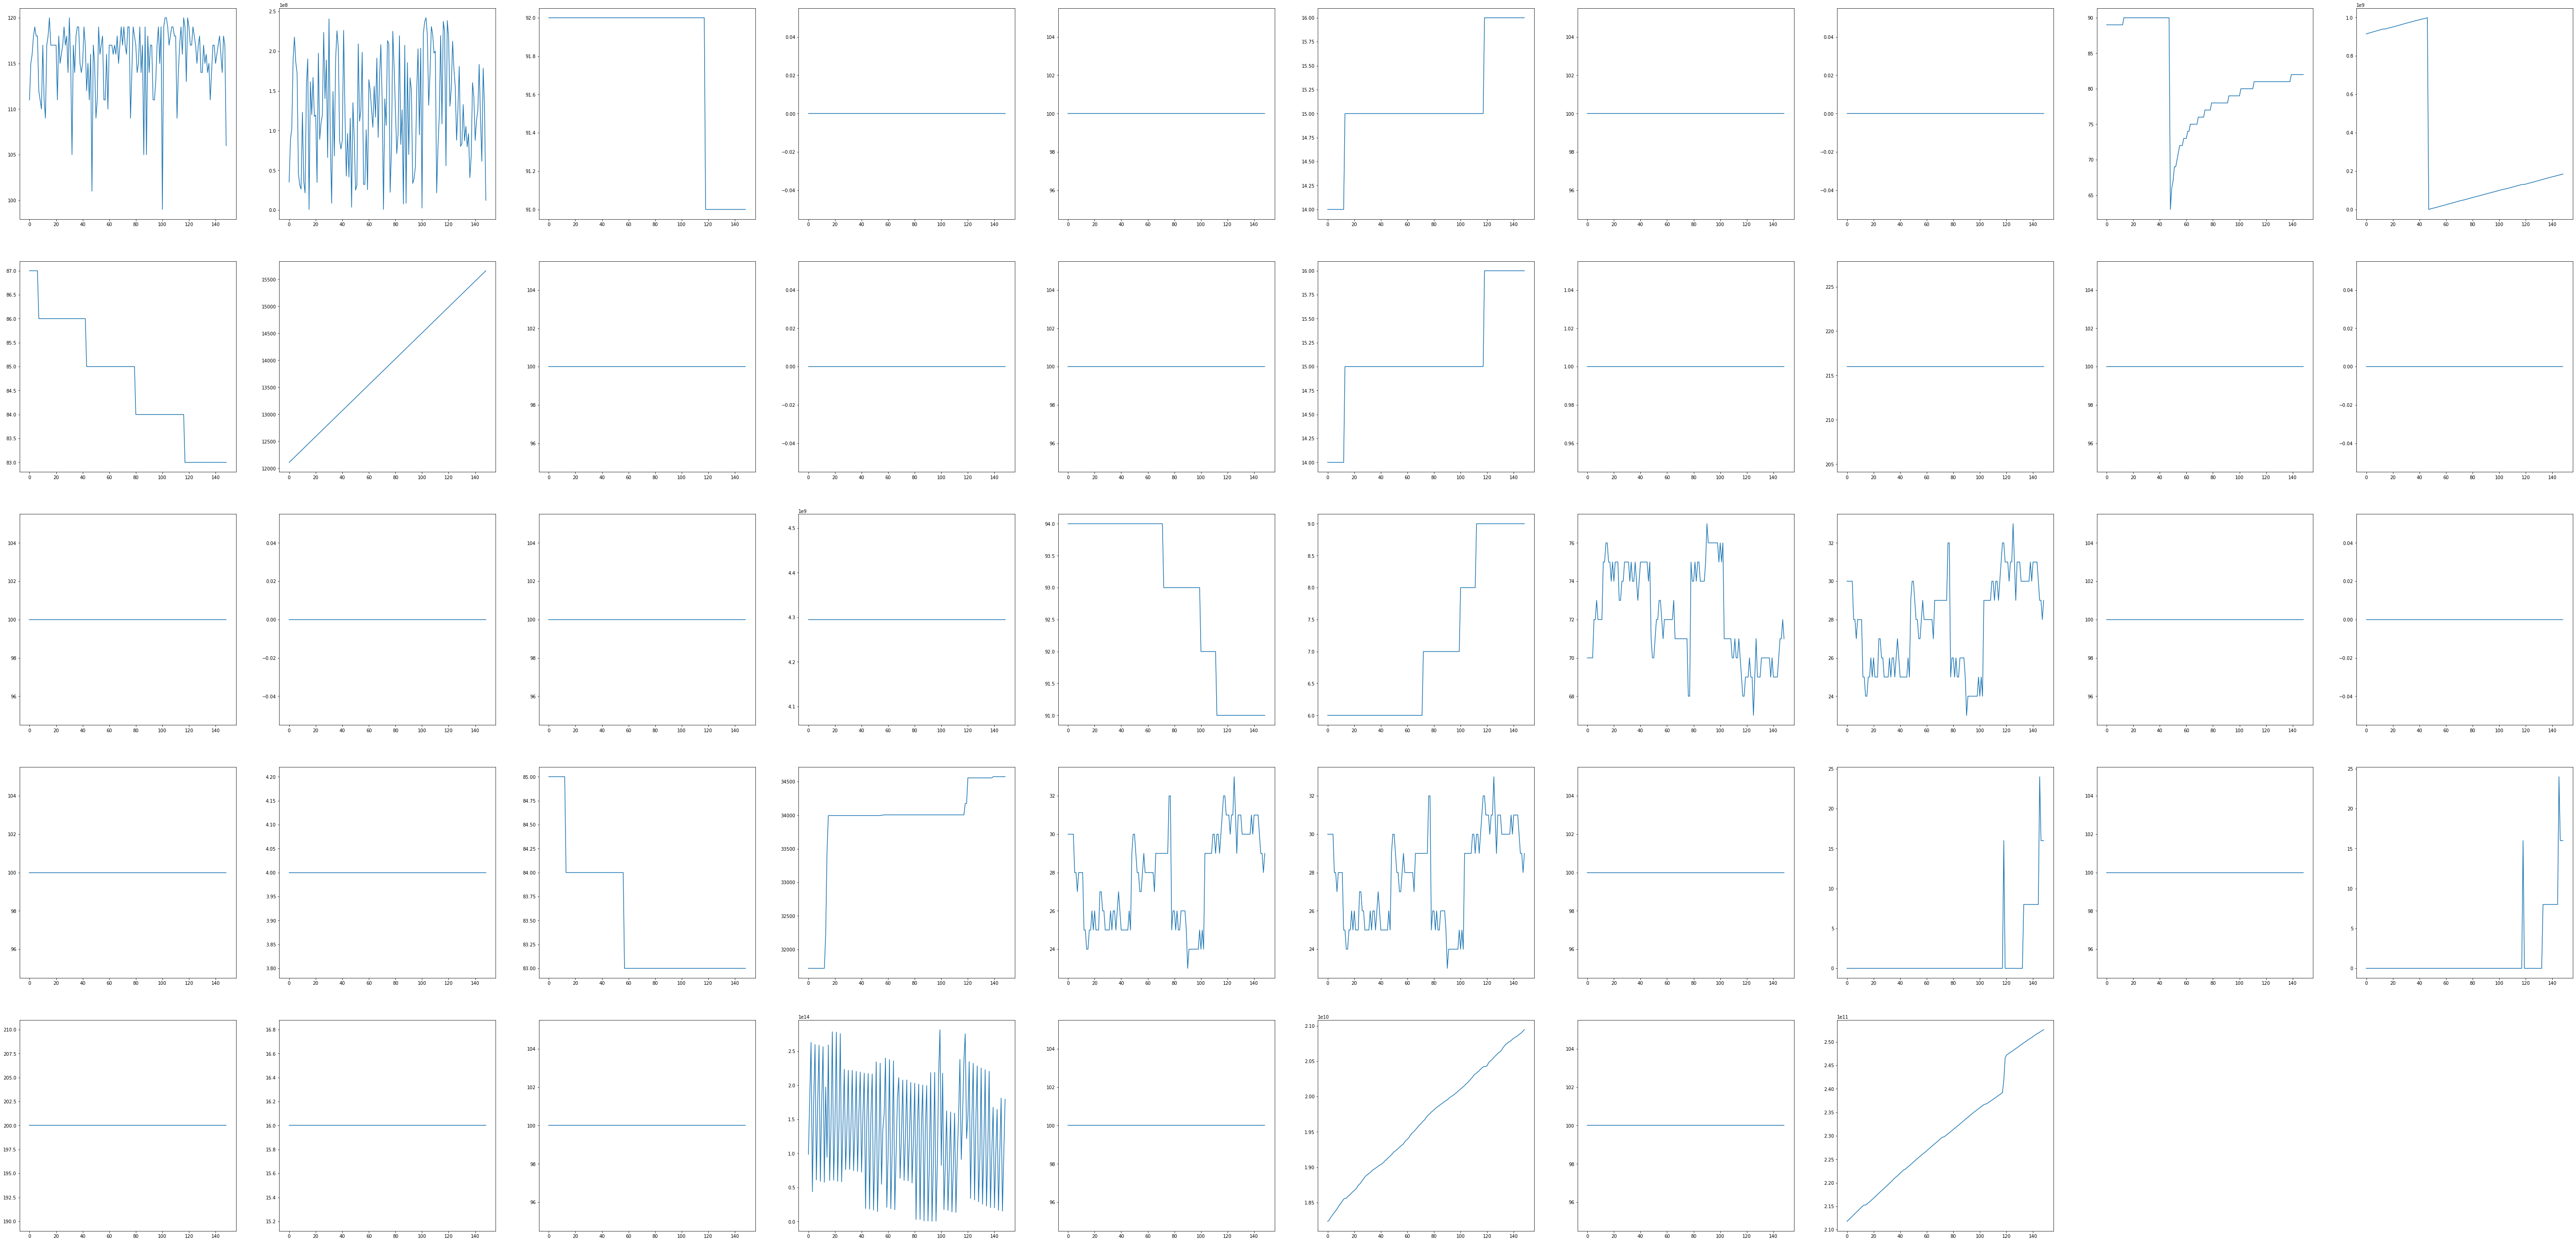

In [115]:
plot_attribute(file_ind=78)

df shape:  (364, 90)
df shape:  (364, 48)


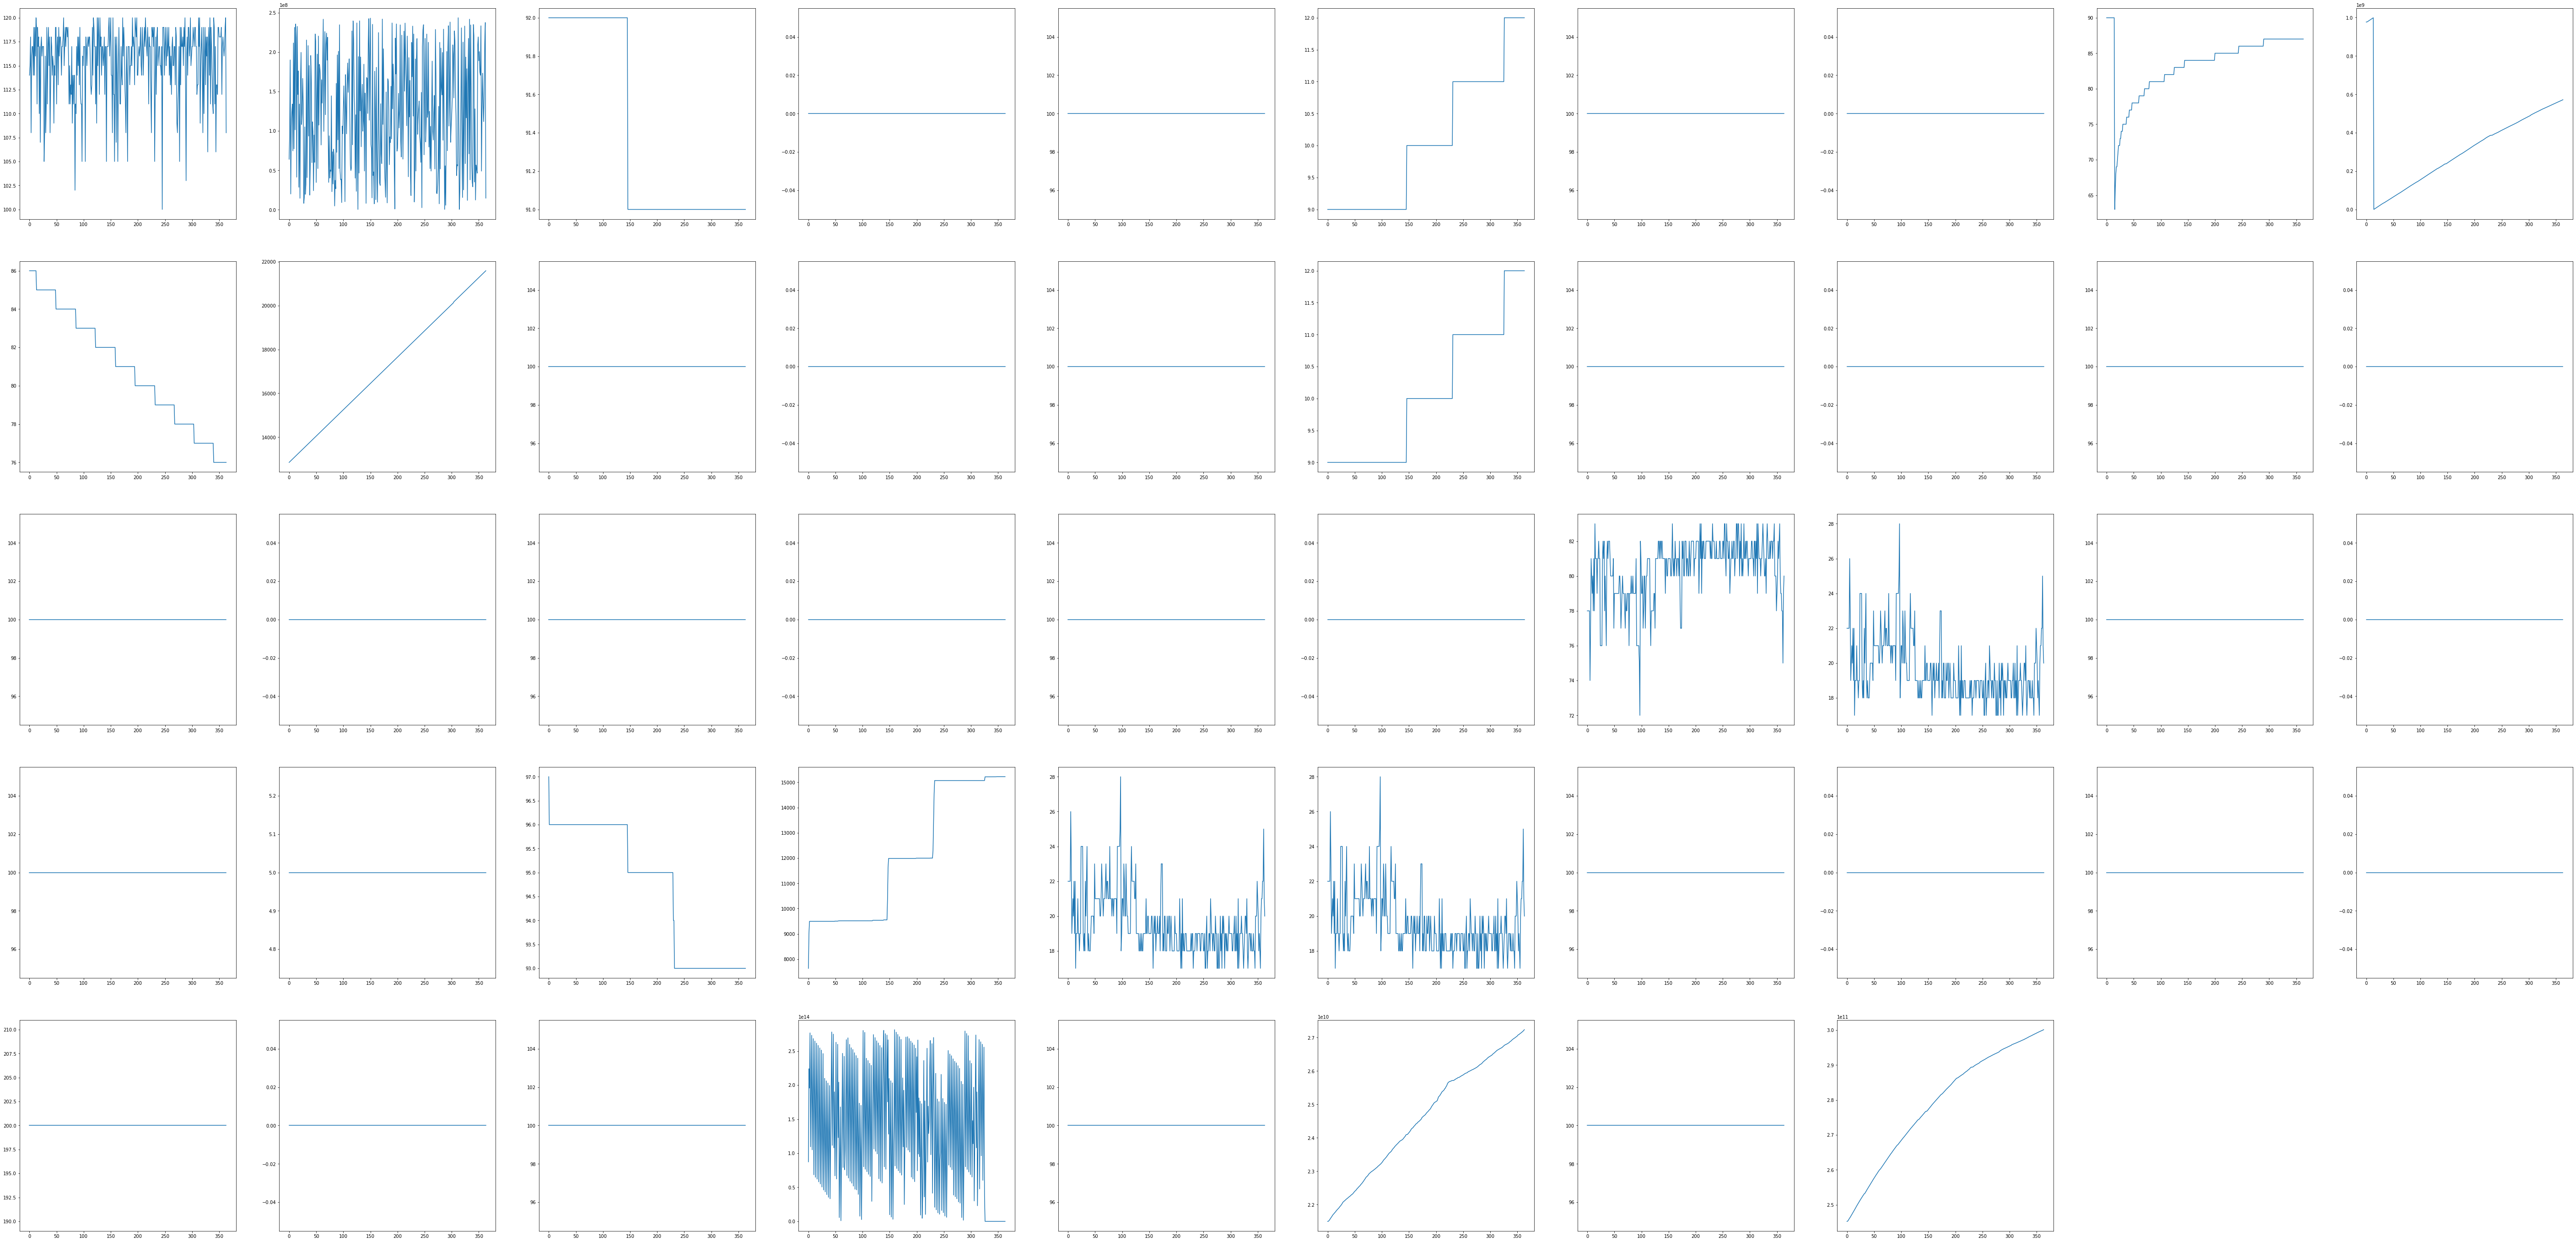

In [114]:
plot_attribute(type='healthy',file_ind=6889)

In [10]:
warnings.simplefilter("ignore")

# 损坏的硬盘的路径
failed_path = Path(f'data/{HARD_DRIVE_MODEL[0]}/failed')
# 正常的硬盘的路径
reference_path = Path(f'data/{HARD_DRIVE_MODEL[0]}/healthy')
# 特征
# existing_columns = pd.read_csv(f'data/{HARD_DRIVE_MODEL[0]}/all_data.csv').columns
# 这里应该是用smart的特征才对的
existing_columns = SMART_ATTRIBUTES

In [12]:
distributions = {}

# 遍历特征，找到每个特征得突变点
for attribute in existing_columns:
    change_point_distribution = distribution_of_significant_change(attribute, 10, failed_path, reference_path,5, 35)
    # 找突变点
    # 保存每个smart属性的突变点位置
    distributions[attribute] = change_point_distribution
    print(f'{attribute}: {change_point_distribution}')
    with open(f'data/{HARD_DRIVE_MODEL[0]}/change_point.json', 'w') as file:
        json.dump(distributions, file)

'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
Smart Attribute: smart_1_normalized has change at None
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has no attribute 'summary_data'
'CausalImpact' object has n

KeyboardInterrupt: 

## Creating the Training and Test datasets

As the healthy data dominates this dataset, we perform informative downsampling via K-means clustering to address the high class imbalance. We only apply informative downsampling on the training data, as doing so on the test data would give an unrepresentative testing score. In the paper they didn't explain exactly how they chose the number of clusters for K-means, so I chose the knee-method.

In [ ]:
# 分割训练集和测试集

import json
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

def get_window_size(data_path: Path) -> dict:
    """
    The window size used per SMART_attribute is the median of all the change_points.
    """
    window_sizes = {}

    with open(data_path / 'change_point.json', 'r') as f:
        change_points = json.load(f)

    for key in change_points.keys():
        distribution = [100 - sample for sample in change_points[key] if sample is not None]
        # In case of constant
        if len(distribution) == 0:
            window_sizes[key] = None
        else:
            window_size = int(round(np.median(distribution)))
            window_sizes[key] = window_size

    return window_sizes


def create_compact_representation(type: str, source_path: Path, data_path: Path, time_before_failure: int) -> None:
    """
    Create a compact representation of the hard drive time series
    :param mode: The mode of data to operate on. Either functioning or failed.
    """
    assert type in ['healthy', 'failed']
    dataframes = []
    window_sizes = get_window_size(source_path)
    for index, data_file in enumerate(os.listdir(source_path / type)):
        df = pd.read_csv(source_path / type / data_file)
        df.drop(df.columns.difference(SMART_ATTRIBUTES), axis=1, inplace=True)

        compact_representation_dict = {}

        for column in df.columns:
            series = df[column].values
            series = series[~np.isnan(series)]

            window_size = window_sizes[column]

            if (window_size is not None) and (len(series) < window_size):
                continue
            if window_size is None and len(series) > 0:  # if the series is constant
                compact_representation_dict[f'{column}_exp_smooth'] = [series[-1]]
            elif (window_size is None and len(series) == 0) or (window_size < time_before_failure):
                continue
            else:
                try:
                    series = series[-window_size:]
                    if time_before_failure > 0:
                        series = series[:-time_before_failure]
                    compact_representation_dict[f'{column}_exp_smooth'] = [exponential_compactness(series)]
                except ConvergenceWarning as e:
                    continue

        df = pd.DataFrame(compact_representation_dict)
        dataframes.append(df)
        if index % 100 == 0:
            print(f'{index} out of {len(os.listdir(source_path / type))}')
    df = pd.concat(dataframes)
    df.to_csv(data_path / f'{type}_compact_representations.csv', index=False)

# 手肘法找 K-means的最佳簇数
def find_best_k(df_scaled: pd.DataFrame) -> int:
    """
    Using the Elbow method, find the optimal number of clusters for the dataset. 
    """

    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    for k in range(1, 25):
        kmeanModel = KMeans(n_clusters=k, n_init=50).fit(df_scaled)

        distortions.append(sum(np.min(cdist(df_scaled.values, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / df_scaled.shape[0])
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(df_scaled.values, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1)) / df_scaled.shape[0]
        mapping2[k] = kmeanModel.inertia_

    knee = KneeLocator(range(1, 25), distortions, curve='convex', direction='decreasing').knee

    return knee

# 欠采样
def down_sample(df: pd.DataFrame, number_of_samples: int) -> pd.DataFrame:
    """
    Perform Information Downsampleing on the functioning hard drive data using KMeans clustering. That is, cluster
    all the data together, and then select the data points closest to the centroid of its nearest cluster. 

    :param number_of_samples: The total number of samples to sample down to.
    :param n_clusters: The number of clusters in KMeans.
    """

    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    scaler = StandardScaler()

    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    n_clusters = find_best_k(df_scaled)
    # n_clusters = 5

    print(f'Using {n_clusters} number of clusters to down sample')

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=75).fit(df_scaled)

    distances = []

    for row in range(df_scaled.shape[0]):
        data_point = df_scaled.iloc[row].values
        data_point = np.expand_dims(data_point, axis=0)
        distances_to_centroids = []
        for cluster in range(kmeans.cluster_centers_.shape[0]):
            cluster_centroid = kmeans.cluster_centers_[cluster, :]
            cluster_centroid = np.expand_dims(cluster_centroid, axis=0)

            distance = euclidean_distances(data_point, cluster_centroid)[0][0]
            distances_to_centroids.append(distance)

        distances.append(min(distances_to_centroids))

    df['distance_from_centroid'] = distances
    df.sort_values(by='distance_from_centroid', inplace=True)
    df.drop('distance_from_centroid', axis=1, inplace=True)
    df = df.iloc[-number_of_samples:]
    return df

# 分割训练集和测试集
def train_test_split(number_of_healthy_samples, data_path: Path):
    """
    Perform informative downsampling on the healthy training data and naive dowsampling on the test data.
    Split the dataset into train_failed, test_failed, test_healthy, train_healthy

    """
    df_healthy = pd.read_csv(data_path / f'healthy_compact_representations.csv').sample(frac=1)
    df_failed = pd.read_csv(data_path / 'failed_compact_representations.csv').sample(frac=1)

    failed_split = int(df_failed.shape[0] * 0.7)

    train_failed = df_failed[:failed_split]
    test_failed = df_failed[failed_split:]

    num_healthy_test = int(number_of_healthy_samples * 0.3)
    num_healthy_train = int(number_of_healthy_samples * 0.7)

    test_healthy = df_healthy[:num_healthy_test]
    train_healthy = down_sample(df_healthy[num_healthy_test:], num_healthy_train)

    train_failed.to_csv(data_path / 'train_failed.csv', index=False)
    test_failed.to_csv(data_path / 'test_failed.csv', index=False)

    test_healthy.to_csv(data_path / 'test_healthy.csv', index=False)
    train_healthy.to_csv(data_path / 'train_healthy.csv', index=False)

# 创建分类的数据
def create_classification_data(number_of_healthy_samples, source_path: Path, data_path: Path, days_in_advance: int):
    create_compact_representation('healthy', source_path, data_path, days_in_advance)
    create_compact_representation('failed', source_path, data_path, days_in_advance)

    train_test_split(number_of_healthy_samples, data_path)


In [ ]:
num_healthy_samples = 400
source_path = Path(f'../data/{HARD_DRIVE_MODEL}')

for i in [0, 4, 9, 14]:
    data_path = Path(f'../data/{HARD_DRIVE_MODEL}/{i}_to_failure')
    if not os.path.isdir(data_path):
        os.mkdir(data_path)
    create_classification_data(num_healthy_samples, source_path, data_path, i)

## Classification

In the paper they used both Regularized Greedy Forest and Gradient Boosting. They got a higher f1 score with RGFs while I got a higher score with GB, but I haven't really done thorough hyper-parameter tuning yet. For now I just included Gradient Boosting.

In [ ]:
# 开始进行分类

from pathlib import Path
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_model(clf, X, y):
    """
    Return various metrics for the given pre-trained classifier.
    """
    predicted = clf.predict(X)

    return {
        'accuracy': accuracy_score(y, predicted),
        'precision': precision_score(y, predicted),
        'recall': recall_score(y, predicted),
        'f1': f1_score(y, predicted)
    }


def combine_and_split(mode: str, data_source: Path):
    """
    Combine the failed and healthy data into a single matrix, shuffle it row wise and produce a lable vector.

    :param mode: specify whether this is training or testing data
    :param data_source: the path of the failed and healthy data. 
    """
    assert mode in ['train', 'test']

    healthy_df = pd.read_csv(data_source / f'{mode}_healthy.csv')
    healthy_df = healthy_df.reindex(sorted(healthy_df.columns), axis=1)
    healthy_df['failed'] = 0

    failed_df = pd.read_csv(data_source / f'{mode}_failed.csv')
    failed_df = failed_df.reindex(sorted(failed_df.columns), axis=1)
    failed_df['failed'] = 1

    df = pd.concat([healthy_df, failed_df])

    # shuffle data
    df = df.sample(frac=1)
    df = df.dropna()

    y = df['failed'].values
    X = df.drop('failed', axis=1).values
    return X, y


def prepare_dataset(data_source: Path):
    """
    Extract X_train, X_test, y_train, y_test out of the failed and healthy data.

    :param data_source: the path of the failed and healthy data. 
    """
    X_train, y_train = combine_and_split('train', data_source)
    X_test, y_test = combine_and_split('test', data_source)

    return X_train, X_test, y_train, y_test


def gradient_boosting(X_train, X_test, y_train, y_test):
    """
    Train the gradient boosting classifier
    """
    param_dict = {
        'max_depth': [2, 4, 6, 8, 10],
        'learning_rate': [0.5, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001],
        'n_estimators': [100, 300, 500, 800, 1000, 1500, 1800, 2000, 2500],
        'min_samples_split': [5, 10, 20, 40, 60, 80, 100],
        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
    }
    
    gbm = GradientBoostingClassifier(max_features='sqrt')
    clf = RandomizedSearchCV(gbm, param_dict, n_jobs=8, n_iter=75, scoring='f1', cv=5)
    search = clf.fit(X_train, y_train)
    return evaluate_model(search, X_test, y_test)

In [ ]:
scores = {}

for _ in range(100):
    for i in [0, 4, 9, 14]:

        data_source = Path(f'data/{HARD_DRIVE_MODEL}/{i}_to_failure')

        X_train, X_test, y_train, y_test = prepare_dataset(data_source)
        metrics = gradient_boosting(X_train, X_test, y_train, y_test)

        if str(i) not in scores:
            scores[str(i)] = {'accuracy': [metrics['accuracy']],
                              'precision': [metrics['precision']],
                              'recall': [metrics['recall']],
                              'f1': [metrics['f1']]}
        else:
            scores[str(i)]['accuracy'].append(metrics['accuracy'])
            scores[str(i)]['precision'].append(metrics['precision'])
            scores[str(i)]['recall'].append(metrics['recall'])
            scores[str(i)]['f1'].append(metrics['f1'])

        print('=' * 50)

In [ ]:
dataframes = {'f1': [], 'accuracy': [], 'recall': [], 'precision': []}
for timestamp in scores:
    for metric in scores[timestamp]:
        df = pd.DataFrame()
        df[timestamp] = scores[timestamp][metric]
        dataframes[metric].append(df)

for metric in dataframes:
    dataframes[metric] = pd.concat(dataframes[metric], axis=1)

In [ ]:
def plot_score(dataframes: list):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,10))
    fig.subplots_adjust(hspace=0.25, wspace=0.25)
    fig.suptitle('Prediction Fidelity', fontsize=20)

    for ax, metric in zip(axes.flatten(), dataframes):
        df = dataframes[metric]
        
        plt.figure(figsize=(16,9))
        df_max = df.mean() + 2* df.std()
        df_min = df.mean() - 2* df.std()
        
        ax.plot([int(col) + 1 for col in df.columns], df.mean(), c='blue', label='Mean Score')
        ax.fill_between([int(col) + 1 for col in df.columns], df_min, df_max, color='red', alpha=0.2, label='95% Conf. Int.')
        
        ax.set_xlabel('days until failure', fontsize=14)
        ax.set_ylabel(f'{metric}', fontsize=14)
        ax.set_title(f'{metric}', fontsize=16)
        ax.set(xticks=[1, 5, 10, 15])
        ax.legend()
    ax.legend(handletextpad=0,loc='upper right') # Plot legend


In [ ]:
plot_score(dataframes)

# Analysis on 2015-2020 Data

I chose the `TOSHIBA MQ01ABF050M` hard drive model as it is particularly rare in the dataset, and would validate to what extent the IBM algorithm can deal with small datasets. In total there are 451 samples, 43 of which fail, and 408 which do not.
 
dataset | training | testing
--- | --- | ---
healthy | 285 | 122
failed | 30 | 13
total| 315 | 135
 
Given that only 30% of the data is used for testing, it is very difficult to get a reliable estimate for the overall scores. To get rough estimates, I performed 100 independent hyper-parameter optimizations using cross validation to get 100 scores. This allowed me to calculate the standard deviation and average score. See below:




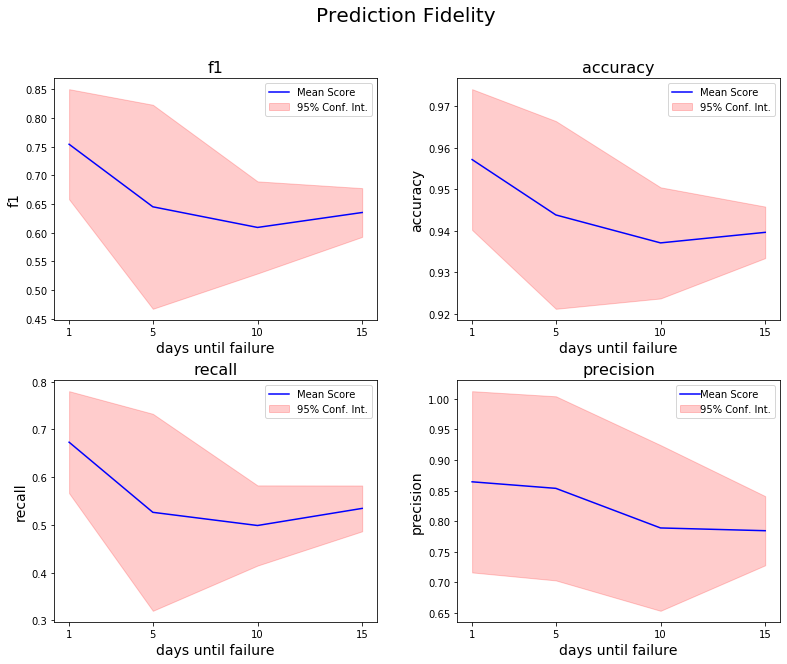

Interestingly the scores do not monotonically decrease. I do not have a clear explanation for why this is. There are two possibility:
1. The test set for 15 days before failure is easier than the test set for 10 days before failure. Afterall with the small test set size, it is entirely possible. Also a mistake I made was to use a different train/test split for 1, 5, 10, and 15 days before failure. The same failing hard drives should be in the all four test sets.  Even better, if I had more time, rather than running 100 cross validation hyper-parameters on the same train-test split, I'd create a new split for each iteration.
2. Since there isn't enough data and these are rough estimates, it's coincidence that the score at 15 days before failure is better than 10 days before failure. This could be especially true as the confidence intervals are so wide.
 

 ## Summary of Failure Stats
 With n=100
 ### One Day Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.754395 | 0.048064
accuracy | 0.957183 | 0.008491
precision| 0.864219 | 0.073963
recall | 0.672930 | 0.053416

 ### Five Days Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.645247 | 0.048064
accuracy | 0.943826 | 0.011325
precision| 0.853533 | 0.075137
recall | 0.526130 | 0.103122

 ### Ten Days Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.609219 | 0.040197
accuracy | 0.937081 | 0.006703
precision| 0.788898 | 0.067631
recall | 0.498532 | 0.041971

 ### Fifteen Days Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.635296 | 0.021277
accuracy | 0.939625 | 0.003108
precision| 0.784406 | 0.028215
recall | 0.534351 | 0.023973


# Analysis on 2019 Data

 dataset | training | testing
--- | --- | ---
healthy | 238 | 102
failed | 15 | 7
total| 253 | 109


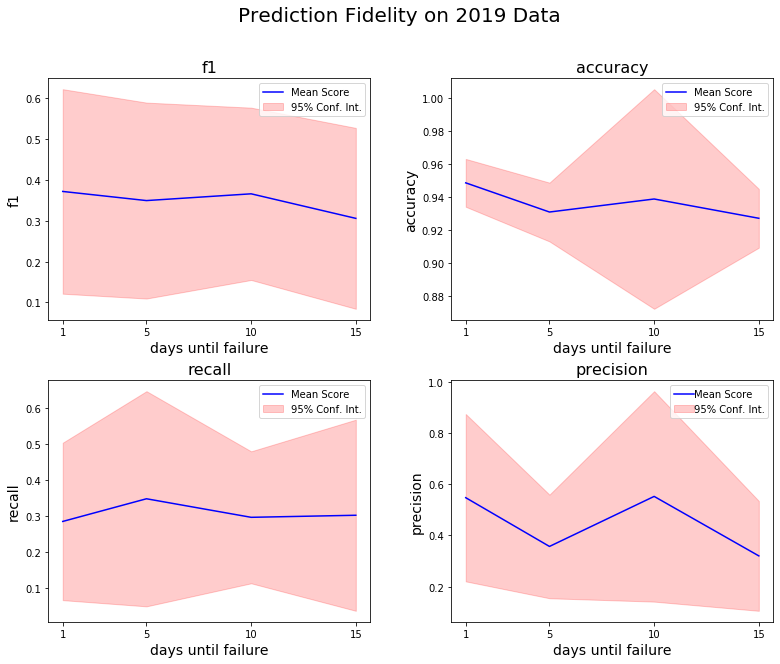

 ## Summary of Failure Stats

 **Note:** Due to time-constraints, the scores below consist of only 25 hyper-parameter tuning iterations (rather than 100 times as above). 
 ### One Day Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.371120 | 0.124895
accuracy | 0.948661 | 0.007231
precision| 0.546667 | 0.163299
recall | 0.285714 | 0.109109

 ### Five Days Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.348813 | 0.119650
accuracy | 0.931024 | 0.008885
precision| 0.356413 | 0.101090
recall | 0.348571 | 0.149147

 ### Ten Days Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.365330 | 0.105224
accuracy | 0.938898 | 0.033196
precision| 0.551686 | 0.205319
recall | 0.297143 | 0.091473

 ### Fifteen Days Before Failure
 
 Metric | Mean Score | Std. Dev.
--- | --- | ---
f1 | 0.305362 | 0.110470
accuracy | 0.927244 | 0.008885
precision| 0.319540 | 0.107189
recall | 0.302857 | 0.132480


# Discussion
 
## What are the most time-consuming or labor-intensive aspects of the replication process? How could we accelerate this part of the development?
 
The most labor and time-consuming aspect of this process is creating compact representations of the time-series data. The process consists of:
 
For each SMART attribute:
1. For a subset of the data, determine the timestamps where the timeseries of a healthy and failed hard drive begin to significantly differ. Call these timestamps change points.
2. Determine the window size to perform exponential smoothing over. This window size is the median of all change points.
3. Perform exponential smoothing.
 
In order to get a stable estimate for the median of all change points, you need to calculate at least 30 change points. This is very expensive as it requires training a bayesian model each time. So if it takes ~30 seconds to train a model, and you have 40 SMART attributes, then overall just determining the window size takes 10 hours (and that is only per model).

To accelerate this process I'd try to move away from requiring hard defined window sizes for each individual SMART attribute. LSTM / CNN networks would do very well at this. The big advantage of those types of algorithms is that they do not have seperate stages for creating representations and classifying these representations. The two steps are linked, one informs the other. 

 
## What are key edge case scenarios you’d like to run to ensure fidelity once deployed across various data centers in the wild?
 
In the wild deployed machine learning algorithms are particularly susceptible to distributional shift. That is if you have one data distribution during training but then during deployment, the distribution slightly shifts, degrading the performance of the algorithm. A key edge case scenario I’d like to explore is to what extent the distribution shifts, and exactly what causes it to shift. I’d expect that the hard-drives degrade differently depending on their exact usage. For example if there’s a lot of IO operations, the SMART attributes may shift. If we do not have a good understanding, or detection algorithm, we'd have to re-train each algorithm periodically on the newest data. This could be prohibitively expensive. So detecting them, and fine-tuning on the new data if necessary will be crucial.
 
An edge-case which even occurred in the BackBlaze dataset is the addition or removal of SMART attributes. The ST4000DM000 model has a different set of SMART attributes in 2013 and 2014 than in 2015-2020. If useful attributes are added, it would be important to be able to use the new attribute while profiting from all the data which was previously collected. .
 
## What are the limitations of IBM paper ML methodology?
 
The key limitation of this algorithm is the necessity for a large window size. The median of all change points per SMART attribute is used to determine the beginning of the window. This leads to some windows being 70 time steps long, requiring the model to have to have been running for 70 days, before the algorithm can be applied to it.
 
The base-case solution for this would be to choose an arbitrary and relatively small window size. This would eliminate the most computationally expensive stage of this algorithm and allow it to be applied to hard drives that haven’t operated for as long. However doing some quick analysis, I reduced the window size to 10 for each SMART attribute, and thereby decreasesed the f1 score by about 3%. 
 
The more advanced solution would be to use a variable length encoding LSTM network. The large advantage would be that it:
1. Can operate on a sequence of any length.
2. Can capture higher order patterns (like periodicity) unlike simple exponential smoothing.
 
Another major limitation (as mentioned in the paper) is exponential smoothing. It assumes that each subsequent time-step is more important (i.e that $S_t$ is less important than $S_{t+1}$). This assumption does not necessarily hold if for example a change in periodicity is indicative of failure.
 
The causal inference algorithm to detect change points in the data is very expensive, and not particularly reliable. I re-ran the algorithm, initialized with a different random seed on the same data, and got wildly different results.
 
In the paper they downsample the healthy dataset by fitting Kmeans to it and choosing the data samples that are closest to a centroid. A problem is that the Kmeans algorithm does not necessarily fit a spherical cluster to the dataset; the clusters can also be elliptical. By just taking the distance to the centroid, you may choose a point along a dimension which has very little expected variance, and thus is not representative of the cluster (see picture below where the blue circle is the cluster, and the two dots are training samples). Instead you should use mahalanobis distance, which takes the variance along each dimension into account.
 
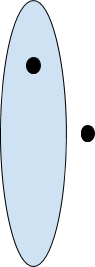
 
## What are other avenues of research and modification to improve performance?
 
A major research avenue to pursue is creating better, richer representations. As discussed above, this would most likely entail using LSTM networks. At the moment, the classification accuracy does not inform the compact representation mechanism. In LSTM or CNN networks (both of which are very valid approaches to this problem) the classification loss adjusts the encoding mechanism. In our case the smoothing parameter $\alpha$ is determined through MLE. One could treat it as a tuneable parameter, and re-run the hyper-parameter tuning session multiple times. For this achritecture that would be prohibitively expensive though. In networks, the gradient of the loss is used to adjust all the encoding parameters, making it a lot more powerful.
 
Another important topic is to look more into down-sampling techniques. I do not understand why you would keep training samples that are closest to a centroid. My understanding is that that would over-sample similar data and not provide the model with a training set that is representative of the true data distribution. Instead you should sample from the area of the cluster, while disrepsecting its density. This would avoid over-sampling nearly identical data-points.
 
As became evident by replicating the IBM paper on hard drive models that occur less frequently in the BackBlaze dataset, the performance drops steeply. It would be good to explore transfer learning between different model types. If we could have one general model that is trained on all data, and then fine-tuned on specific models, it would reduce the total number of unique algorithms, and be potentially a lot more powerful. Given that in the IBM paper they were so succesful at transfer-learning between different models of the same series with such a basic transfer-learning approach, I'd be suprised if there wasn't an advantage even between series.

Another important research step is finding representative metrics. It's not trivially true that F1, recall and precision is what we care about most.